In [1]:
# load data and consider two features (Economy..GDP.per.capita, Freedom) and the output to be estimated (Happiness.Score)
import csv

def loadData(fileName, inputVariabNames, outputVariabName):
    data = []
    dataNames = []
    with open(fileName) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                dataNames = row
            else:
                data.append(row)
            line_count += 1  
              
    inputs =  [ [ 1 for _ in range(len(inputVariabNames) + 1)  ] for _ in range(len(data)) ]
    for j in range(len(inputVariabNames)):
        selectedVariable = dataNames.index(inputVariabNames[j])
        for i in range(len(data)): 
            inputs[i][j + 1] = float(data[i][selectedVariable])
    selectedOutput = dataNames.index(outputVariabName)
    outputs = [float(data[i][selectedOutput]) for i in range(len(data))]
    
    return inputs, outputs


import os

crtDir =  os.getcwd()
filePath = os.path.join(crtDir, 'data', 'world-happiness-report-2017.csv')

inputs, outputs = loadData(filePath, ['Economy..GDP.per.Capita.', 'Freedom'], 'Happiness.Score')
print('in:  ', inputs[:5])
print('out: ', outputs[:5])

in:   [[1, 1.61646318435669, 0.635422587394714], [1, 1.48238301277161, 0.626006722450256], [1, 1.480633020401, 0.627162635326385], [1, 1.56497955322266, 0.620070576667786], [1, 1.44357192516327, 0.617950856685638]]
out:  [7.53700017929077, 7.52199983596802, 7.50400018692017, 7.49399995803833, 7.4689998626709]


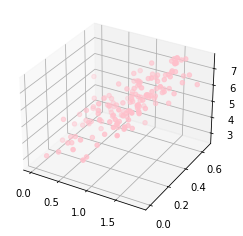

In [2]:
# check the liniarity
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
ax = plt.axes(projection = '3d')
x = [row[1] for row in inputs]
y = [row[2] for row in inputs]
z = outputs
ax.scatter3D(x, y, z, color = 'pink')

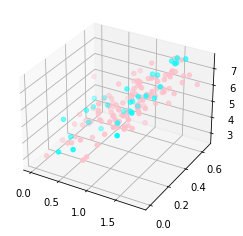

In [3]:
import numpy as np 

# Split the Data Into Training and Test Subsets
# In this step we will split our dataset into training and testing subsets (in proportion 80/20%).

# Training data set is used for learning the linear model. Testing dataset is used for validating of the model. All data from testing dataset will be new to model and we may check how accurate are model predictions.

np.random.seed(5)
indexes = [i for i in range(len(inputs))]
trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
validationSample = [i for i in indexes  if not i in trainSample]

trainInputs = [inputs[i] for i in trainSample]
trainOutputs = [outputs[i] for i in trainSample]

validationInputs = [inputs[i] for i in validationSample]
validationOutputs = [outputs[i] for i in validationSample]

fig = plt.figure()
ax = plt.axes(projection = '3d')
x = [row[1] for row in trainInputs]
y = [row[2] for row in trainInputs]
z = trainOutputs
ax.scatter3D(x, y, z, color = 'pink')
x2 = [row[1] for row in validationInputs]
y2 = [row[2] for row in validationInputs]
z2 = validationOutputs
ax.scatter3D(x2, y2, z2, color = 'cyan')

In [4]:
class MyRegression:
    def __init__(self):
        self.w = []
    # learn a linear multivariate regression model by using training inputs (x = matrix noSamples x noFeats + 1 with first column 1) and outputs (y) 
    def fit(self, x, y):
        # W = (Xt*X)^-1 * Xt * Y 
        # calculate x transpose:
        trans = self.matrixTranspose(x)
        # calculate the product of x transpose and x:
        self.w = self.matrixMult(trans, x)
        # calculate the inverse:
        self.w = self.matrixInverse(self.w)
        # multiply by x transpose
        self.w = self.matrixMult(self.w, trans)
        # multiply by y
        self.w = self.matrixMult(self.w, y)

        
    # predict the outputs for some new inputs (by using the learnt model)
    def predict(self, x):
        return [self.w[0][0] + self.w[1][0] * line[0] + self.w[2][0] * line[1]  for line in x]

    def matrixTranspose(self, x):
        trans = []
        for i in range(len(x[0])):
            trans.append([row[i] for row in x])
        return trans
    
    def matrixMult(self, x, y):
        # multiplying 2 matrix
        result = [[0 for _ in range(len(y[0]))] for _ in range(len(x))]
        # iterate through rows of x
        for i in range(len(x)):
        # iterate through columns of y
            for j in range(len(y[0])):
            # iterate through rows of y
                for k in range(len(y)):
                    result[i][j] += x[i][k] * y[k][j]
        return result
    
    def matrixInverse(self, x):
        # inv = 1/det(x) * adj(x)
        adj = self.matrixAdjugate(x)
        for i in range(len(x)):
            for j in range(len(x)):
               adj[i][j] *= 1 / self.matrixDeterminant(x)
        return adj


    def matrixAdjugate(self, x):
        # adj = transpose(cofactor)
        result = []
        for i in range(len(x)):
            row = []
            for j in range(len(x)):
                sign = pow(-1, i + j)
                d = sign * self.matrixDeterminant(self.clippedMatrix(x, i, j))
                row.append(d)
            result.append(row)
        result = self.matrixTranspose(result)
        return result
                
    def clippedMatrix(self, x, si, sj):
        # clipped matrix for the elemnt at row si and column sj
        result = []
        for i in range(len(x)):
            row = []
            if i == si:
                continue
            for j in range(0, len(x)):
                if j != sj:
                    row.append(x[i][j])        
            result.append(row)
        return result

        
    def matrixDeterminant(self, x):
        # recursively calculate the determinant
        result = 0
        sign = -1

        if len(x) == 2:
            return x[0][0] * x[1][1] - x[0][1] * x[1][0]

        for k in range(0, len(x)):
            nx = []
            for i in range(1, len(x)):
                row = []
                for j in range(0, len(x)):
                    if j != k:
                        row.append(x[i][j])
                nx.append(row)
            sign *= -1
            result += sign * x[0][k] * self.matrixDeterminant(nx)

        return result

In [5]:
# learning step: init and train a linear regression model y = f(x) = w0 + w1 * x
# Prediction step: used the trained model to estimate the output for a new input
from random import randint
import pdb
# model initialisation
regressor = MyRegression()
# training the model by using the training inputs and known training outputs
outputsComputed = [[x] for x in trainOutputs]
regressor.fit(trainInputs, outputsComputed)

[w0], [w1], [w2] = regressor.w[0], regressor.w[1], regressor.w[2]
print('the learnt model: f(x) = ', w0, ' + ', w1, ' * x1 + ', w2 ,' * x2' )

the learnt model: f(x) =  2.528366317190806  +  1.8763387358813073  * x1 +  2.3147487475032853  * x2


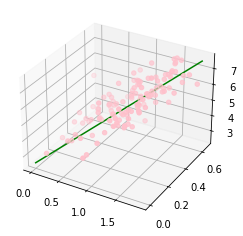

In [6]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

# plot the learnt model
noOfPoints = 1000
x1line = []
x2line = []

x1 = [row[1] for row in trainInputs]
x2 = [row[2] for row in trainInputs]
y = trainOutputs
valx1 = min(x1)
valx2 = min(x2)
stepx1 = (max(x1) - min(x1)) / noOfPoints
stepx2 = (max(x2) - min(x2)) / noOfPoints 
for i in range(1, noOfPoints):
    x1line.append(valx1)
    valx1 += stepx1
    x2line.append(valx2)
    valx2 += stepx2
yline = [w0 + w1 * el1 + w2 * el2 for el1, el2 in zip(x1line, x2line)]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(x1, x2, y, color = 'pink')
ax.plot3D(x1line, x2line, yline, 'green')


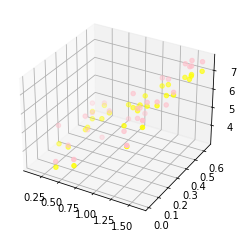

In [7]:
# use the trained model to predict new inputs

xx = [[line[1], line[2]] for line in validationInputs]
computedValidationOutputs = regressor.predict(xx)

# plot the computed outputs (see how far they are from the real outputs)

validationInputs = [inputs[i] for i in validationSample]
validationOutputs = [outputs[i] for i in validationSample]

fig = plt.figure()
ax = plt.axes(projection = '3d')
x = [row[1] for row in validationInputs]
y = [row[2] for row in validationInputs]
z = validationOutputs
ax.scatter3D(x, y, z, color = 'pink')
z2 = computedValidationOutputs
ax.scatter3D(x, y, z2, color = 'yellow')

In [8]:
error = sum((r - c) ** 2 for r, c in zip(validationOutputs, computedValidationOutputs)) / len(validationOutputs)
print(error)

0.27782674347210223
